## Database creation and cleaning for English dataset
#### The current notebook needs the "posts_english.xml" file inside the raw_dataset folder in order to run properly.
The dataset is read, parsed and exported into three CSV files (train, validation and test).
It labels the questions based on their "score" property between 1 (good) and 0 (bad) question. These labels are calculated given the median score of all questions considered for the training set.

In [ ]:
# INSTALL LIBRARIES AND DOWNLOAD FILES
# !pip install py7zr
# !wget https://archive.org/download/stackexchange/electronics.stackexchange.com.7z

In [ ]:
# UNZIP FILE
'''
import py7zr
print(py7zr.__version__)
import py7zr
with py7zr.SevenZipFile('/content/electronics.7z', mode='r') as z:
    z.extractall("/content/data")
'''

In [7]:
#Parse XML to CSV (cleaning data)
import xml.etree.ElementTree as ET
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import random
import re

In [9]:
#Class to hold all scores in the dataset
class Scores:
    def __init__(self):
        #Array of all scores
        self.scores_list = []
        self.median = None

    def append(self, score):
        #append question to dictionary
        self.scores_list.append(score)
        
    def process(self):
        # orders scores and find median
        # call before trying to score something
        self.scores_list.sort()
        self.median = self.scores_list[len(self.scores_list)//2]
        
    #Function that returns the label given the num of likes
    def get_label(self, likes):
        return 0 if likes < self.median else 1

In [10]:
#Create Scores objects based on all questions in the dataset
scores = Scores()
i = 0
quest = True
quest_id, ans_id = None, None
for event, elem in ET.iterparse("../raw_dataset/posts_english.xml"):
    #Check if type is question and we're reading the next question
    if quest and elem.tag == "row" and event == "end" and elem.attrib["PostTypeId"] == "1":
        year = str(elem.attrib["CreationDate"]).split("T")[0].split("-")[0]
        if int(year) >= 2010 and int(year) < 2020:
            if "AcceptedAnswerId" in elem.attrib:
                quest = False
                ans_id = elem.attrib["AcceptedAnswerId"]
                quest_id = elem.attrib["Id"]
    #Check if type is answer and we're reading accepted answer of previous question
    elif not quest and elem.tag == "row" and event == "end" and elem.attrib["PostTypeId"] == "2" and elem.attrib["Id"] == ans_id:
        #Found the answer accepted for question
        scores.append(int(elem.attrib["Score"]))
        i += 1
        quest = True
    #Clear element to release memory
    elem.clear()
    if i % 10000 == 0 and i > 0:
        print(i)
        
print("Processing scores...")
scores.process()

#for scorer in scores.values():
#    scorer.process()


Processing scores...


332
test other value: 0
test other value: 1


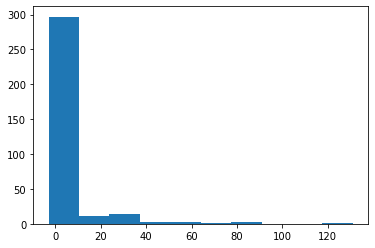

In [11]:
print(i)
print("test other value:", scores.get_label(0))
print("test other value:", scores.get_label(2))

plt.hist(scores.scores_list)
plt.show()

In [5]:
data_size = 108364
data_split = data_size

idx_val = set(random.sample(range(data_split),int(data_split*0.05)))
idx_test = set()
for i in range(int(data_split*0.05)):
    n = random.randint(0, data_split-1)
    while n in idx_val or n in idx_test:
        n = random.randint(0, data_split-1)
    idx_test.add(n)
print(len(idx_test))
print(len(idx_val))
print(len(idx_test.intersection(idx_val)))
z = np.zeros(data_split)
z[list(idx_test)] = 1
z[list(idx_val)] = 2
print(np.count_nonzero(z == 0))
print(np.count_nonzero(z == 1))
print(np.count_nonzero(z == 2))

5418
5418
0
97528
5418
5418


In [6]:
#Parse XML to CSV (cleaning data)

#Creates list of tags given the string
def createTags(tags):
    return "|".join(tags[1:-1].split("><"))

#Clean sentence (remove non alpha chars)
def cleanSentence(sentence):
    p = re.compile(r'<.*?>')
    sentence = p.sub('', sentence) 
    sentence = ''.join([(i.lower() if i.isalpha() else " ") for i in sentence if i.isalpha() or i == " " or i == "-"])
    return sentence
    
#Opens CSV file to write parsed rows
i, j = 0, 0
with open('../processed_files/english_train.csv', mode='w', newline='',encoding="utf8", buffering=1) as data_file:
    with open('../processed_files/english_test.csv', mode='w', newline='',encoding="utf8", buffering=1) as data_file_test:
        with open('../processed_files/english_val.csv', mode='w', newline='',encoding="utf8", buffering=1) as data_file_val:
            #Headers for train
            data_writer = csv.writer(data_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            data_writer.writerow(["stars","title","tags","score","creation_date"]) #write headers
            #Headers for test
            data_writer_test = csv.writer(data_file_test, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            data_writer_test.writerow(["stars","title","tags","score","creation_date"]) #write headers
            #Headers for val
            data_writer_val = csv.writer(data_file_val, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            data_writer_val.writerow(["stars","title","tags","score","creation_date"]) #write headers
            #Loop to iterate through every element on the XML file
            for event, elem in ET.iterparse("../raw_dataset/posts_english.xml"):
                #Write row if tag is row and post type is 1 (meaning it is a question)
                if elem.tag == "row" and event == "end" and elem.attrib["PostTypeId"] == "1":
                    if i % (data_size//data_split) == 0:
                        score = int(elem.attrib["Score"])
                        if j in idx_test:
                            data_writer_test.writerow([scores.get_label(score),cleanSentence(elem.attrib["Title"]),createTags(elem.attrib["Tags"].lower()),elem.attrib["Score"],elem.attrib["CreationDate"],cleanSentence(elem.attrib["Body"])])
                        elif j in idx_val:
                            data_writer_val.writerow([scores.get_label(score),cleanSentence(elem.attrib["Title"]),createTags(elem.attrib["Tags"].lower()),elem.attrib["Score"],elem.attrib["CreationDate"],cleanSentence(elem.attrib["Body"])])
                        else:
                            data_writer.writerow([scores.get_label(score),cleanSentence(elem.attrib["Title"]),createTags(elem.attrib["Tags"].lower()),elem.attrib["Score"],elem.attrib["CreationDate"],cleanSentence(elem.attrib["Body"])])  
                        j += 1
                    i += 1
                elem.clear()
                if i % 10000 == 0:
                    print(i)
                if j == data_split:
                    break


10000
10000
10000
10000
20000
20000
20000
30000
30000
30000
30000
30000
30000
30000
40000
40000
40000
40000
40000
40000
40000
40000
40000
50000
50000
60000
70000
80000
90000
90000
90000
100000
100000


In [ ]:
#Find stars for given score
def stars(score, ranges):
    if score < ranges[0]:
        return 1
    elif score < ranges[1]:
        return 2
    elif score < ranges[2]:
        return 3
    elif score < ranges[3]:
        return 4
    else:
        return 5

#Create array with all scores
scores = []
i = 0
for event, elem in ET.iterparse("Posts.xml"):
    #Add score if type is question
    if elem.tag == "row" and event == "end" and elem.attrib["PostTypeId"] == "1":
        scores.append(int(elem.attrib["Score"]))
        i += 1
        elem.clear()
    if i == data_size:
        break
#Sort the list of scores
scores.sort()
l = len(scores)
ranges = [scores[int(0.2*l)], scores[int(0.4*l)], scores[int(0.6*l)], scores[int(0.8*l)]]

# New section